In [77]:
#Import Bibliotecas
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [78]:
#Parameter

#Lebensdauer
lifespan_pv = 20 #Jahre
lifespan_hp = 20 #Jahre
lifespan_battery = 15 #Jahre 
lifespan_heat_store = 25 #Jahre
#Betriebskosten
marginal_cost_pv = 30 #€/MWh
marginal_cost_hp = 20 #€/MWh
grid_cost = 150 #€/MWh
#Annuitäten/Kapitalkosten
pv_annuity = 65000  #€/(MW*a) 
hp_annuity = 48000  #€/(MW*a) 
battery_annuity = 25 #€/(kWh*a) 
heat_store_annuity = 5 #€/(kWh*a) 
#Effizienz
storage_loss_heat = 0.005 
#CO2 Emissionen
co2_grid = 428 # kg CO2 pro MWh 
#Leistungen
inhouse_pv = 0.35 #Leistung der PV Anlage in MW
#wärmepumpen Leistungsdaten
    # Umgebungstemperatur in °C
temp        = [-20, -15, -10,  -7,   2,   7,  10,  20,  30,  35] 
    # Elektrische Leistungsaufnahme in kW 
el_power    = [10.2, 10.4, 10.6, 10.8, 11.2, 11.5, 11.7, 12.0, 12.2, 12.5] 
    # Leistungszahl (COP) der Wärmepumpe bei 35°C Vorlauftemperatur
cop         = [1.65, 1.90, 2.20, 2.50, 3.40, 4.60, 5.10, 6.20, 7.10, 7.50]
    # Nominale thermische Leistung (P_th) bei A7/W35 (Referenzpunkt)
hp_p_nom_kw = 39.5  # kW (thermisch)
hp_p_nom    = hp_p_nom_kw / 1000  # MW (umgerechnet für PyPSA!)


In [79]:
# Zeitprofile
# Lade das Solar-Profil für Deutschland
renewable_profile_solar = pd.read_csv("pv_profile.csv", usecols=["electricity"]) ["electricity"].astype(float)  # Stündliches, normiertes PV-Erzeugungsprofil
# Building load als csv datei einlesen (kW → MW)
electric_load_profile = pd.read_csv("building_load_G4.csv", usecols=["Last [kW]"])["Last [kW]"].astype(float) / 1000  # In MW

# Building thermal load als csv datei einlesen (kW → MW)
thermal_load_bww = pd.read_csv("bww_load.csv", header=None)[1].astype(float) / 1000  # In MW
thermal_load_heating = pd.read_csv("building_heat_load.csv", header=None)[1].astype(float) / 1000  # In MW

# Temperatur profile
temperature_profile = pd.read_csv("temprature_profile.csv", header=None)[2].astype(float)

# Fleet load profile (kW → MW)
fleet_load_profile = pd.read_csv("fleet_load.csv", header=None)[1].astype(float) / 1000  # In MW

# Interpolation für jede Stunde des Jahres 
cop_profile = np.interp(temperature_profile, temp, cop)
el_p_pu_profile = np.interp(temperature_profile, temp, el_power) / hp_p_nom_kw

In [80]:
#netzwerk erstellen with_batterie
with_battery = pypsa.Network()
with_battery.set_snapshots(range(8760))

In [81]:
#hinzufügen bus
with_battery.add("Bus", name="electricity bus", carrier="electricity")
with_battery.add("Bus", name= "h_bus", carrier="heat")
with_battery.add("Bus", name= "h_bus2", carrier="heat")

In [82]:
#hinzufügen generatoren
with_battery.add("Generator", name="PV", bus="electricity bus", p_max_pu=renewable_profile_solar, marginal_cost=marginal_cost_pv, lifetime=lifespan_pv, overwrite=True ) 
with_battery.add("Generator", name="Grid", bus="electricity bus", p_nom_extendable=True, marginal_cost=grid_cost, overwrite=True )  

In [83]:
#hinzufügen last
with_battery.add("Load", name="building_load", bus="electricity bus", p_set=electric_load_profile)
with_battery.add("Load", name="fleet_load", bus="electricity bus", p_set=fleet_load_profile)
with_battery.add("Load", name="DHW_Load",bus="h_bus", p_set=thermal_load_bww)
with_battery.add("Load", name="heating_Load",bus="h_bus2", p_set=thermal_load_heating)


In [84]:
#Links
# Wärmepumpe 1: Raumheizung (h_bus2)
with_battery.add("Link", name="h_pump", 
                 bus0="electricity bus", 
                 bus1="h_bus2", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_nom = hp_p_nom,  # Feste Nennleistung
                 capital_cost=hp_annuity)  

# Wärmepumpe 2: Warmwasser (h_bus)
with_battery.add("Link", name="h_pump2", 
                 bus0="electricity bus", 
                 bus1="h_bus", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_nom = hp_p_nom,
                 capital_cost=hp_annuity)  


In [85]:
#hinzufügen Wärmespeicher
with_battery.add("Store", name="DHW_Storage", bus="h_bus", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=heat_store_annuity, storage_loss=storage_loss_heat
                 )  
with_battery.add("Store", name="Thermal_Storage", bus="h_bus2", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=heat_store_annuity)

In [86]:
#hinzufügen Batteriespeicher
with_battery.add("Store", name="Battery", bus="electricity bus", carrier="electricity", e_nom_extendable=True, e_cyclic=True, capital_cost=battery_annuity)

In [87]:
# PV-Leistungsvariationen (in MW) 
pv_variations = inhouse_pv * np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 4.0])  # 100%-1000% der ursprünglichen PV-Leistung

# Spaltennamen definieren - eine Spalte pro PV-Variation
column_names = ['PV-Leistung 0.0x', 'PV-Leistung 0.5x', 'PV-Leistung 1x', 'PV-Leistung 1.5x', 'PV-Leistung 2x', 'PV-Leistung 2.5x', 'PV-Leistung 4x']


df_results = pd.DataFrame(
    columns=column_names, 
    index=['Netzbezug (MWh)', 'Autarkie (%)', 'Batteriekapazität (MWh)', 'Batteriekosten (€)', 
           'Wärmespeicherkapazität (MWh)', 'Wärmespeicherkosten (€)', 'DHW Speicherkapazität (MWh)', 
           'DHW Speicherkosten (€)', 'Wärmepumpen Kapazität (MW)', 'Wärmepumpen Kosten (€)', 
           'Stromersparnis Wärmepumpe (MWh)', 'Stromersparnis PV (MWh)', 'Gesamte Stromersparnis (MWh)',
           'Jährliche Kosteneinsparung (€)', 'Amortisationszeit (Jahre)', 'Gesamtinvestition (€)', 
           'Eingesparte elektrische Energie (MWh)', 'Benötigte elektrische Energie (MWh)','pv_energy (MWh)'],
    dtype=float
)


# Schleife zur Berechnung der Netzbezug und Autarkie für ALLE PV-Leistungen (inkl. Baseline)
for i, pv_power in enumerate(pv_variations):
    with_battery.generators.at["PV", "p_nom"] = pv_power
    with_battery.optimize(solver_name='highs')
    
    # Netzbezug berechnen
    grid_energy = with_battery.generators_t.p["Grid"].sum()
    
    battery_capacity = with_battery.stores.at["Battery", "e_nom_opt"]  # MWh
    battery_cost = with_battery.stores.at["Battery", "capital_cost"]  # €/MWh
    battery_investment = battery_capacity * battery_cost

    thermal_storage_capacity = with_battery.stores.at["Thermal_Storage", "e_nom_opt"]
    thermal_storage_cost = with_battery.stores.at["Thermal_Storage", "capital_cost"]
    thermal_storage_investment = thermal_storage_capacity * thermal_storage_cost

    dhw_storage_capacity = with_battery.stores.at["DHW_Storage", "e_nom_opt"]
    dhw_storage_cost = with_battery.stores.at["DHW_Storage", "capital_cost"]
    dhw_storage_investment = dhw_storage_capacity * dhw_storage_cost

    h_pump_capacity = with_battery.links.at["h_pump", "p_nom_opt"]
    h_pump2_capacity = with_battery.links.at["h_pump2", "p_nom_opt"] 
    h_pump_capacity_mw = h_pump_capacity + h_pump2_capacity 
    investment_costs_h_pumps = h_pump_capacity_mw * hp_annuity
    investment_costs_pv = pv_power * pv_annuity
    total_investment_costs = investment_costs_h_pumps + investment_costs_pv + battery_investment + thermal_storage_investment + dhw_storage_investment

    # Stromverbrauch der Wärmepumpen (elektrische Energie rein)
    h_pump_electricity = with_battery.links_t.p0["h_pump"].sum()  # MWh (Strom)
    h_pump2_electricity = with_battery.links_t.p0["h_pump2"].sum()  # MWh (Strom)
    total_hp_electricity = h_pump_electricity + h_pump2_electricity

    # Wärmeerzeugung der Wärmepumpen (thermische Energie raus)
    h_pump_heat = with_battery.links_t.p1["h_pump"].sum()  # MWh (Wärme)
    h_pump2_heat = with_battery.links_t.p1["h_pump2"].sum()  # MWh (Wärme)
    total_hp_heat = h_pump_heat + h_pump2_heat

    electricity_saved_with__pump = (total_hp_heat + total_hp_electricity) * -1
    pv_energy = with_battery.generators_t.p["PV"].sum()
    electricity_saved_with_pv = pv_energy  # MWh (direkt von PV genutzt)
    total_electricity_saved = electricity_saved_with__pump + electricity_saved_with_pv

    annual_savings = total_electricity_saved * grid_cost
    amortization_time = total_investment_costs / annual_savings 



    # Autarkie berechnen
    total_electricity_demand = (with_battery.loads_t.p["building_load"].sum() + 
                                with_battery.loads_t.p["fleet_load"].sum() + 
                                with_battery.links_t.p0["h_pump"].sum() + 
                                with_battery.links_t.p0["h_pump2"].sum())
    autarky_calc = (pv_energy / total_electricity_demand) * 100 if total_electricity_demand > 0 else 0

    col_name = column_names[i]     # Verwende den Index direkt für die Spaltennamen
    
    df_results.loc['Netzbezug (MWh)', col_name] = grid_energy
    df_results.loc['Autarkie (%)', col_name] = autarky_calc
    df_results.loc['Batteriekapazität (MWh)', col_name] = battery_capacity 
    df_results.loc['Batteriekosten (€)', col_name] = battery_investment
    df_results.loc['Wärmespeicherkapazität (MWh)', col_name] = thermal_storage_capacity 
    df_results.loc['Wärmespeicherkosten (€)', col_name] = thermal_storage_investment
    df_results.loc['DHW Speicherkapazität (MWh)', col_name] = dhw_storage_capacity 
    df_results.loc['DHW Speicherkosten (€)', col_name] = dhw_storage_investment
    df_results.loc['Wärmepumpen Kapazität (MW)', col_name] = h_pump_capacity_mw
    df_results.loc['Wärmepumpen Kosten (€)', col_name] = investment_costs_h_pumps
    df_results.loc['Stromersparnis Wärmepumpe (MWh)', col_name] = electricity_saved_with__pump
    df_results.loc['Stromersparnis PV (MWh)', col_name] = electricity_saved_with_pv
    df_results.loc['Gesamte Stromersparnis (MWh)', col_name] = total_electricity_saved
    df_results.loc['Jährliche Kosteneinsparung (€)', col_name] = annual_savings
    df_results.loc['Amortisationszeit (Jahre)', col_name] = amortization_time
    df_results.loc['Gesamtinvestition (€)', col_name] = total_investment_costs
    df_results.loc['Eingesparte elektrische Energie (MWh)', col_name] = total_electricity_saved
    df_results.loc['Benötigte elektrische Energie (MWh)', col_name] = total_electricity_demand
    df_results.loc['pv_energy (MWh)', col_name] = pv_energy
# Tabelle anzeigen
print("\nSensitivitätsanalyse: Einfluss der PV-Leistung auf Netzbezug und Autarkie")

print(df_results.round(2))


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 302.28it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-xyp6eab_ has 175204 rows; 87604 cols; 315364 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [5e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [6e-05, 8e-01]
Presolving model
61320 rows, 61323 cols, 166440 nonzeros  0s
49653 rows, 49656 cols, 147371 nonzeros  0s
Dependent equations search running on 22493 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
48773 rows, 48776 cols, 150988 nonzeros  0s
Presolve reductions: rows 48773(-126431); columns 48776(-38828); nonzeros 150988(-164376) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7857583050e-03 Pr: 22763(8011.72) 0s
      27622     5.8627463501e+05 Pr: 8761(31605.5) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 175204 duals
Objective: 5.87e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      31601     5.8730761929e+05 Pr: 0(0) 6s
      31601     5.8730761929e+05 Pr: 0(0) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-xyp6eab_
Model status        : Optimal
Simplex   iterations: 31601
Objective value     :  5.8730761929e+05
P-D objective error :  2.5272856011e-14
HiGHS run time      :          6.35


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 309.87it/s]
INFO:linopy.io: Writing time: 0.26s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-n_s1k3bg has 175204 rows; 87604 cols; 315364 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [5e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [1e-09, 8e-01]
Presolving model
61320 rows, 65427 cols, 170544 nonzeros  0s
49653 rows, 53760 cols, 151475 nonzeros  0s
Dependent equations search running on 22493 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
48773 rows, 52880 cols, 155092 nonzeros  0s
Presolve reductions: rows 48773(-126431); columns 52880(-34724); nonzeros 155092(-160272) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7952744113e-03 Pr: 22763(8011.72) 0s
      24231     5.5879377664e+05 Pr: 8772(17016.5); Du: 0(2.25076e-15) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 175204 duals
Objective: 5.60e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      29573     5.5983195177e+05 Pr: 0(0) 6s
      29573     5.5983195177e+05 Pr: 0(0) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-n_s1k3bg
Model status        : Optimal
Simplex   iterations: 29573
Objective value     :  5.5983195170e+05
P-D objective error :  1.7051631003e-14
HiGHS run time      :          6.49


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 311.80it/s]
INFO:linopy.io: Writing time: 0.26s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-brjd4v7m has 175204 rows; 87604 cols; 315364 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [5e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 8e-01]
Presolving model
61320 rows, 65433 cols, 170550 nonzeros  0s
49653 rows, 53766 cols, 151481 nonzeros  0s
Dependent equations search running on 22493 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
48773 rows, 52886 cols, 155098 nonzeros  0s
Presolve reductions: rows 48773(-126431); columns 52886(-34718); nonzeros 155098(-160266) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7819544024e-03 Pr: 22763(8011.72) 0s
      23060     5.3132748708e+05 Pr: 8770(31724.3) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 175204 duals
Objective: 5.32e+05
Solver model: available
Solver message: Optimal



      27077     5.3236848834e+05 Pr: 0(0) 6s
      27077     5.3236848834e+05 Pr: 0(0) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-brjd4v7m
Model status        : Optimal
Simplex   iterations: 27077
Objective value     :  5.3236848830e+05
P-D objective error :  3.7939960405e-14
HiGHS run time      :          6.42


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 265.77it/s]
INFO:linopy.io: Writing time: 0.28s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-u2mgwf8g has 175204 rows; 87604 cols; 315364 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [5e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [4e-09, 8e-01]
Presolving model
61320 rows, 65434 cols, 170551 nonzeros  0s
49653 rows, 53767 cols, 151482 nonzeros  0s
Dependent equations search running on 22493 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
48773 rows, 52887 cols, 155099 nonzeros  0s
Presolve reductions: rows 48773(-126431); columns 52887(-34717); nonzeros 155099(-160265) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7641167287e-03 Pr: 22763(8011.72) 0s
      19801     5.0386428235e+05 Pr: 8766(15898.4); Du: 0(3.35128e-15) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 175204 duals
Objective: 5.05e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      25450     5.0490578776e+05 Pr: 0(0); Du: 0(4.26326e-14) 6s
      25450     5.0490578776e+05 Pr: 0(0); Du: 0(4.26326e-14) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-u2mgwf8g
Model status        : Optimal
Simplex   iterations: 25450
Objective value     :  5.0490578772e+05
P-D objective error :  3.5738067285e-14
HiGHS run time      :          6.60


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 246.32it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-tvywhkb7 has 175204 rows; 87604 cols; 315364 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [5e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [5e-09, 8e-01]
Presolving model
61320 rows, 65436 cols, 170553 nonzeros  0s
49653 rows, 53769 cols, 151484 nonzeros  0s
Dependent equations search running on 22493 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
48773 rows, 52889 cols, 155101 nonzeros  0s
Presolve reductions: rows 48773(-126431); columns 52889(-34715); nonzeros 155101(-160263) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7998174948e-03 Pr: 22763(8011.72) 0s
      21260     4.7640943622e+05 Pr: 8766(38288.7); Du: 0(5.96917e-08) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 175204 duals
Objective: 4.77e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      24910     4.7744796976e+05 Pr: 0(0); Du: 0(2.84217e-14) 6s
      24910     4.7744796976e+05 Pr: 0(0); Du: 0(2.84217e-14) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-tvywhkb7
Model status        : Optimal
Simplex   iterations: 24910
Objective value     :  4.7744796973e+05
P-D objective error :  7.0893000956e-14
HiGHS run time      :          6.30


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 318.48it/s]
INFO:linopy.io: Writing time: 0.26s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-j5n3x8z6 has 175204 rows; 87604 cols; 315364 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [5e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [6e-09, 9e-01]
Presolving model
61320 rows, 65437 cols, 170554 nonzeros  0s
49653 rows, 53770 cols, 151485 nonzeros  0s
Dependent equations search running on 22493 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
48773 rows, 52890 cols, 155102 nonzeros  0s
Presolve reductions: rows 48773(-126431); columns 52890(-34714); nonzeros 155102(-160262) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7843153236e-03 Pr: 22763(8011.72) 0s
      14529     4.3600303972e+05 Pr: 16722(184398); Du: 0(9.95994e-08) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 175204 duals
Objective: 4.50e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      24332     4.4999647695e+05 Pr: 0(0) 7s
      24332     4.4999647695e+05 Pr: 0(0) 7s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-j5n3x8z6
Model status        : Optimal
Simplex   iterations: 24332
Objective value     :  4.4999647693e+05
P-D objective error :  7.4053577204e-14
HiGHS run time      :          6.82


Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 342.82it/s]
INFO:linopy.io: Writing time: 0.26s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-i_tfgy1a has 175204 rows; 87604 cols; 315364 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [5e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [1e-08, 1e+00]
Presolving model
61320 rows, 65438 cols, 170555 nonzeros  0s
49653 rows, 53771 cols, 151486 nonzeros  0s
Dependent equations search running on 22493 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
48773 rows, 52891 cols, 155103 nonzeros  0s
Presolve reductions: rows 48773(-126431); columns 52891(-34713); nonzeros 155103(-160261) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7769162498e-03 Pr: 22763(8011.72) 0s
      14187     3.5365809320e+05 Pr: 16651(178257) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 175204 duals
Objective: 3.68e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      23734     3.6766529634e+05 Pr: 0(0) 7s
      23734     3.6766529634e+05 Pr: 0(0) 7s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-i_tfgy1a
Model status        : Optimal
Simplex   iterations: 23734
Objective value     :  3.6766529633e+05
P-D objective error :  6.3010074026e-14
HiGHS run time      :          6.70

Sensitivitätsanalyse: Einfluss der PV-Leistung auf Netzbezug und Autarkie
                                       PV-Leistung 0.0x  PV-Leistung 0.5x  \
Netzbezug (MWh)                                 3902.39           3673.34   
Autarkie (%)                                       0.00              5.87   
Batteriekapazität (MWh)                           -0.00              0.40   
Batteriekosten (€)                                -0.00              9.98   
Wärmespeicherkapazität (MWh)                     373.02            373.02   
Wärmespeicherkosten (€)                         1865.11           1865.11

In [88]:
#CO2 berechnen
for col in df_results.columns:

    total_electricity_saved = df_results.loc['Eingesparte elektrische Energie (MWh)', col]

    total_electricity_demand = df_results.loc['Netzbezug (MWh)', col]

    co2_einsparung = total_electricity_saved * co2_grid  # kg CO2    print(f"  Spezifische CO2-Einsparung: {(co2_einsparung_tonnen/total_electricity_demand)*1000:>10,.2f} kg/MWh")

    co2_einsparung_tonnen = co2_einsparung / 1000  # Tonnen CO2    print(f"  CO2-Einsparung:             {co2_einsparung_tonnen:>10,.2f} Tonnen/Jahr")
    
    total_co2_use = total_electricity_demand * co2_grid
    pv_energy = df_results.loc['pv_energy (MWh)', col]

    
    print(f"  CO2 verbrauch:                        {total_co2_use:>10,.2f} Tonnen/Jahr")
    print(f"  CO2-Einsparung:             {co2_einsparung_tonnen:>10,.2f} Tonnen/Jahr")


  CO2 verbrauch:                        1,670,223.36 Tonnen/Jahr
  CO2-Einsparung:                 195.15 Tonnen/Jahr
  CO2 verbrauch:                        1,572,191.20 Tonnen/Jahr
  CO2-Einsparung:                 293.18 Tonnen/Jahr
  CO2 verbrauch:                        1,474,161.86 Tonnen/Jahr
  CO2-Einsparung:                 391.21 Tonnen/Jahr
  CO2 verbrauch:                        1,376,132.73 Tonnen/Jahr
  CO2-Einsparung:                 489.24 Tonnen/Jahr
  CO2 verbrauch:                        1,278,100.34 Tonnen/Jahr
  CO2-Einsparung:                 587.27 Tonnen/Jahr
  CO2 verbrauch:                        1,180,072.66 Tonnen/Jahr
  CO2-Einsparung:                 685.30 Tonnen/Jahr
  CO2 verbrauch:                        885,988.49 Tonnen/Jahr
  CO2-Einsparung:                 979.38 Tonnen/Jahr


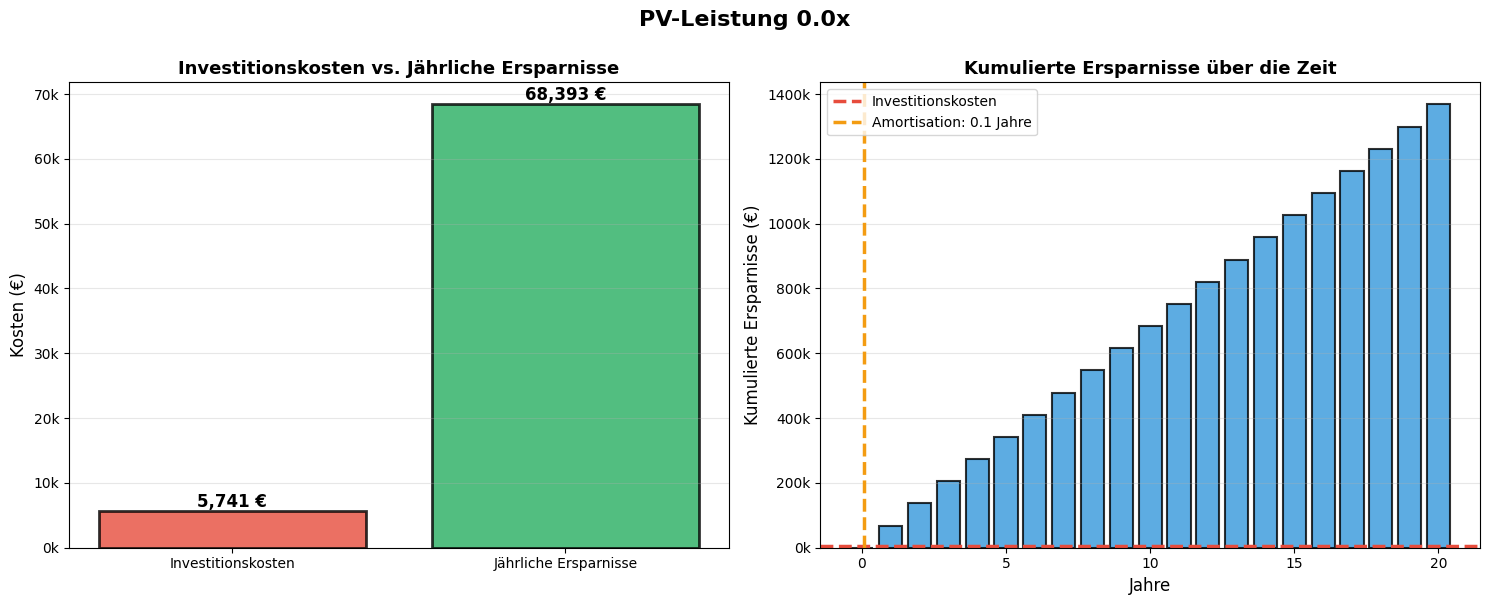


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 0.0X
Gesamtinvestitionen:                  5,741 €
Jährliche Ersparnisse:               68,393 €
Amortisationszeit:                     0.08 Jahre
Ersparnisse nach 10 Jahren:         683,932 €
Ersparnisse nach 20 Jahren:       1,367,865 €


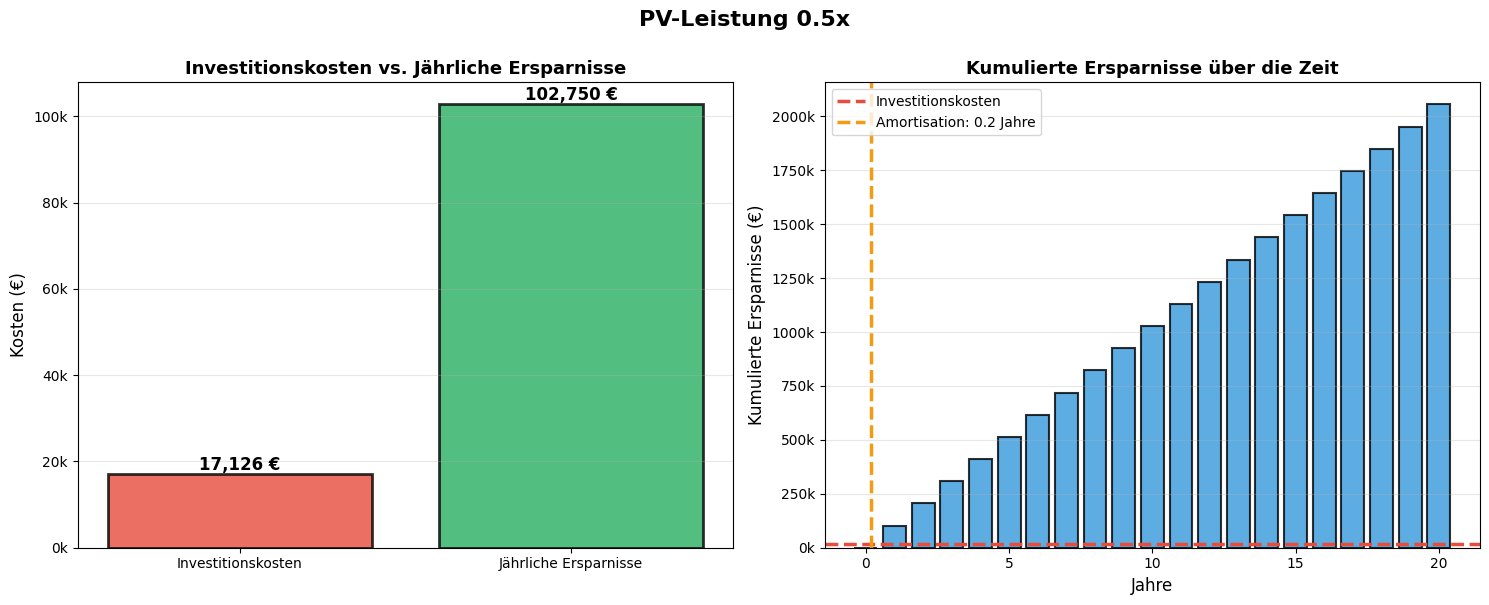


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 0.5X
Gesamtinvestitionen:                 17,126 €
Jährliche Ersparnisse:              102,750 €
Amortisationszeit:                     0.17 Jahre
Ersparnisse nach 10 Jahren:       1,027,503 €
Ersparnisse nach 20 Jahren:       2,055,006 €


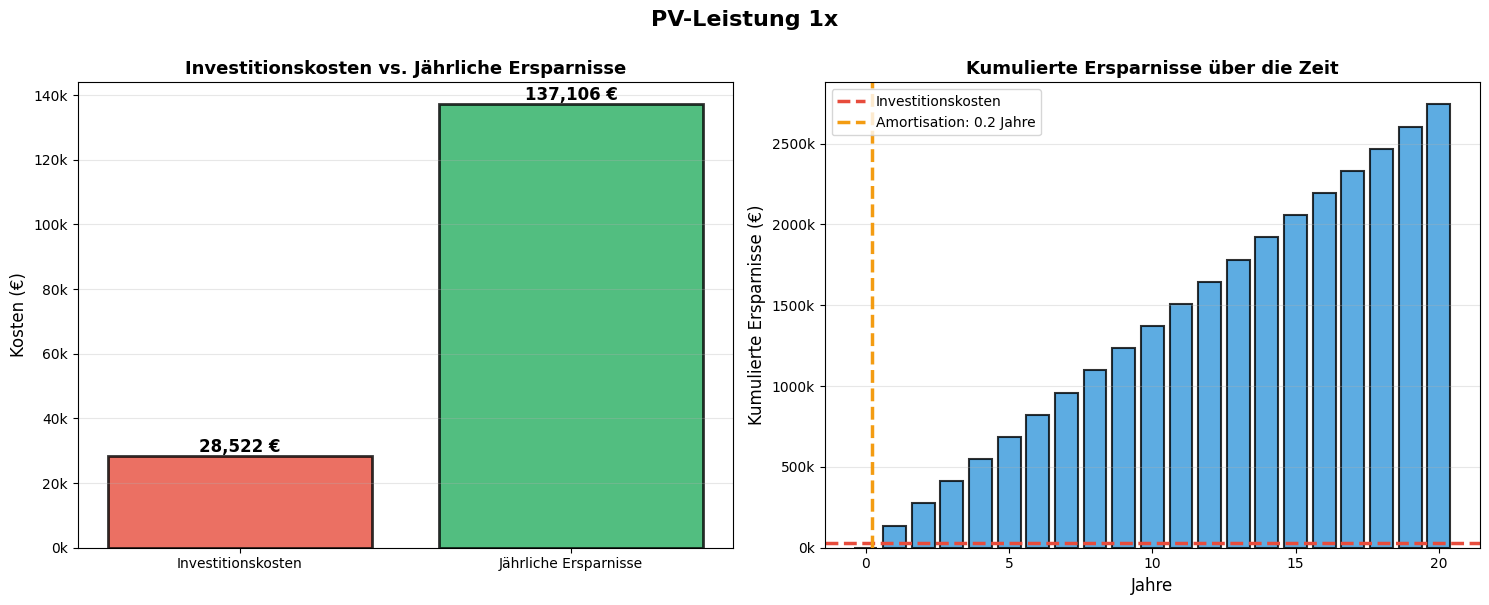


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 1X
Gesamtinvestitionen:                 28,522 €
Jährliche Ersparnisse:              137,106 €
Amortisationszeit:                     0.21 Jahre
Ersparnisse nach 10 Jahren:       1,371,064 €
Ersparnisse nach 20 Jahren:       2,742,127 €


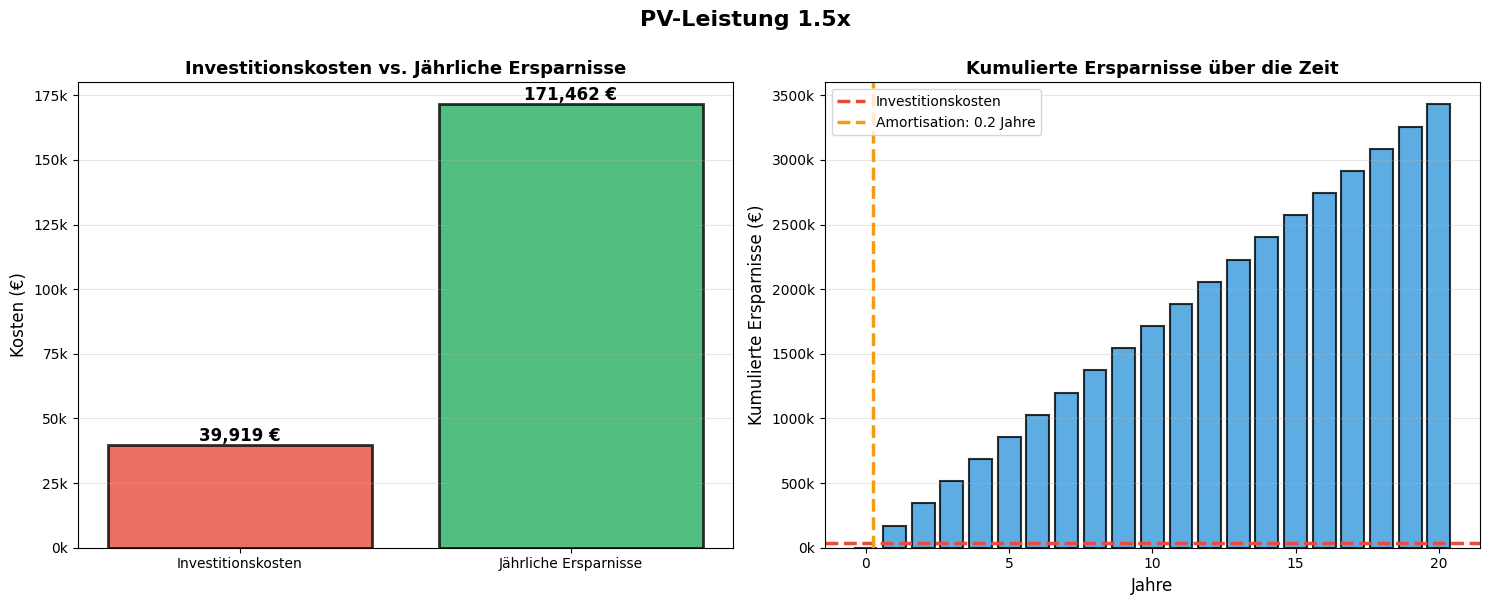


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 1.5X
Gesamtinvestitionen:                 39,919 €
Jährliche Ersparnisse:              171,462 €
Amortisationszeit:                     0.23 Jahre
Ersparnisse nach 10 Jahren:       1,714,624 €
Ersparnisse nach 20 Jahren:       3,429,248 €


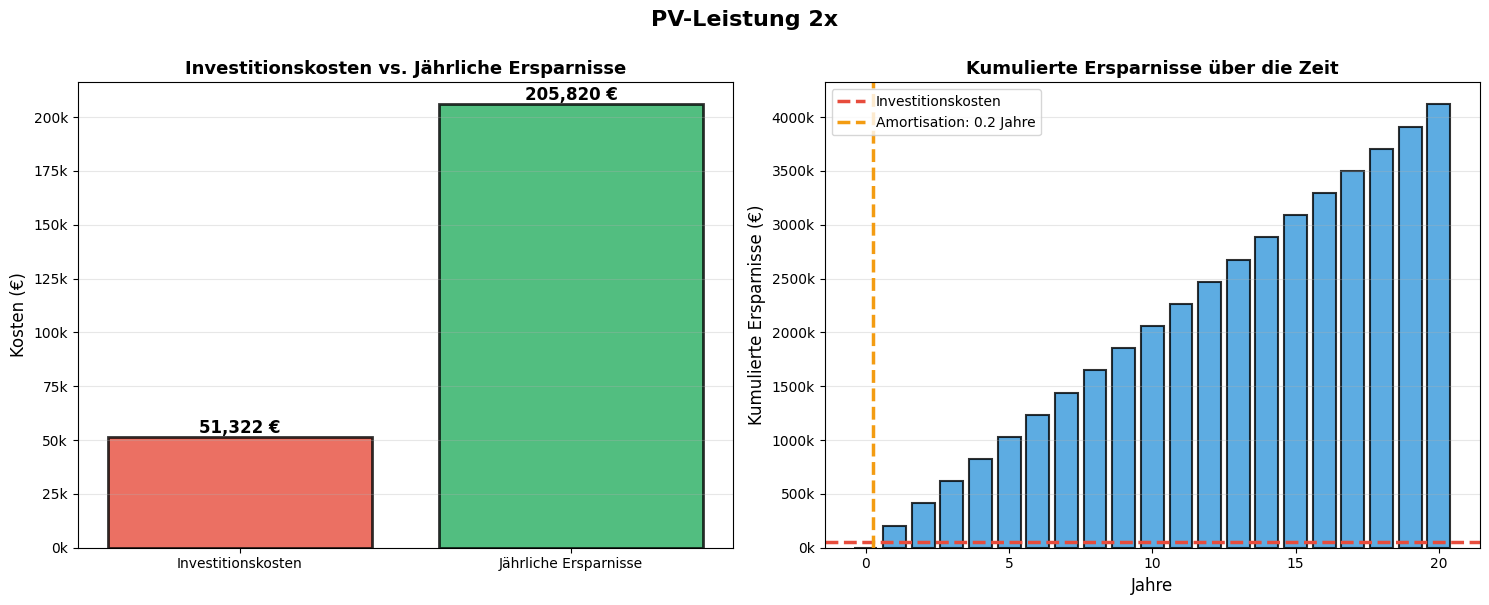


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 2X
Gesamtinvestitionen:                 51,322 €
Jährliche Ersparnisse:              205,820 €
Amortisationszeit:                     0.25 Jahre
Ersparnisse nach 10 Jahren:       2,058,195 €
Ersparnisse nach 20 Jahren:       4,116,390 €


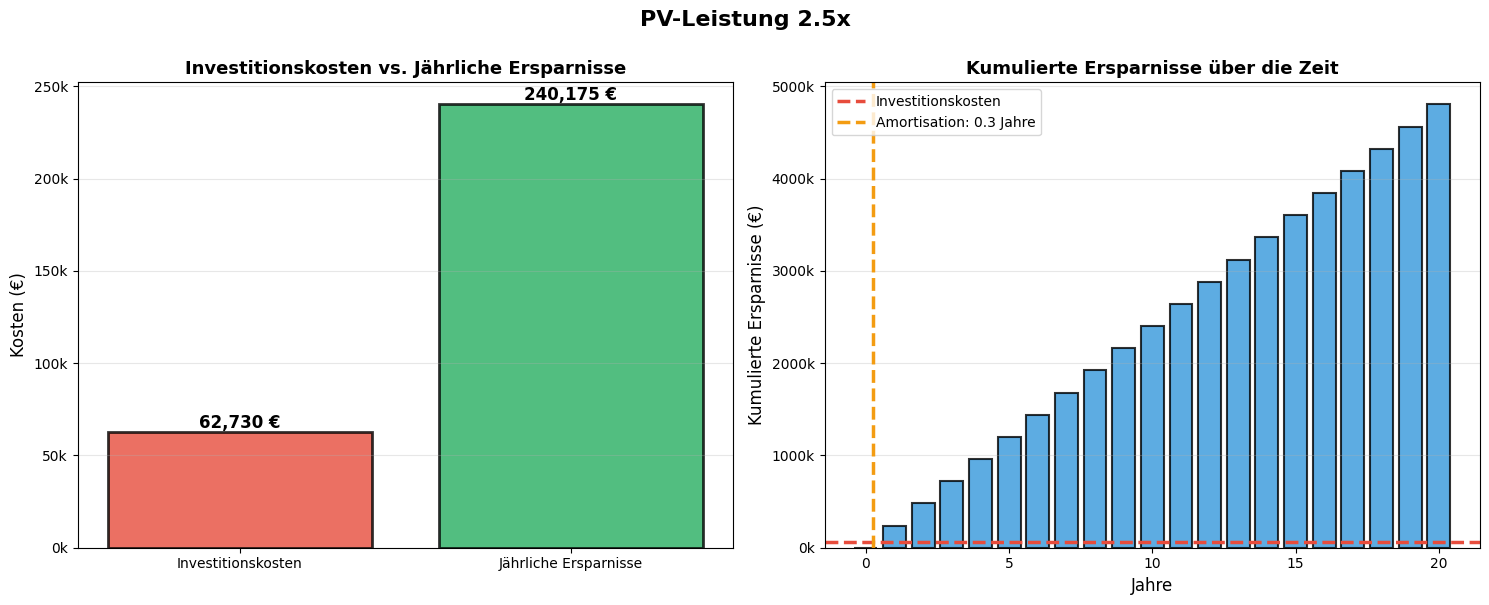


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 2.5X
Gesamtinvestitionen:                 62,730 €
Jährliche Ersparnisse:              240,175 €
Amortisationszeit:                     0.26 Jahre
Ersparnisse nach 10 Jahren:       2,401,750 €
Ersparnisse nach 20 Jahren:       4,803,500 €


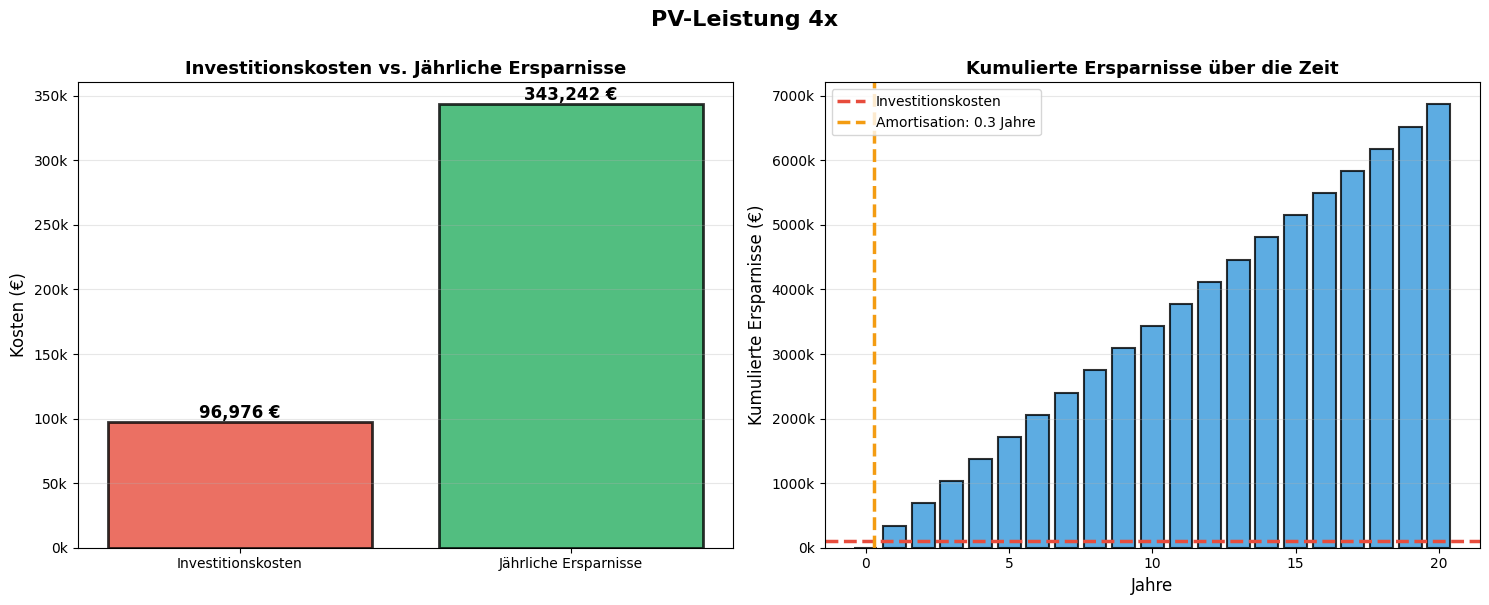


WIRTSCHAFTLICHKEITSANALYSE - PV-LEISTUNG 4X
Gesamtinvestitionen:                 96,976 €
Jährliche Ersparnisse:              343,242 €
Amortisationszeit:                     0.28 Jahre
Ersparnisse nach 10 Jahren:       3,432,419 €
Ersparnisse nach 20 Jahren:       6,864,838 €


In [89]:
# Vergleich: Investitionskosten vs. Ersparnisse für ALLE PV-Szenarien

# Schleife durch alle Spalten (PV-Szenarien)
for col in df_results.columns:
    # Daten für aktuelles Szenario extrahieren
    total_investment_costs_plot = df_results.loc['Gesamtinvestition (€)', col]
    annual_savings_plot = df_results.loc['Jährliche Kosteneinsparung (€)', col]
    
    # Erstelle das Balkendiagramm
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'{col}', fontsize=16, fontweight='bold', y=1.00)
    
    # Diagramm 1: Investitionskosten vs. jährliche Ersparnisse
    categories = ['Investitionskosten', 'Jährliche Ersparnisse']
    values = [total_investment_costs_plot, annual_savings_plot]
    colors = ['#E74C3C', '#27AE60']
    
    bars1 = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Werte auf den Balken anzeigen
    for bar, value in zip(bars1, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{value:,.0f} €',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax1.set_ylabel('Kosten (€)', fontsize=12)
    ax1.set_title('Investitionskosten vs. Jährliche Ersparnisse', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))
    
    # Diagramm 2: Kumulierte Ersparnisse über Jahre
    years = np.arange(0, 21)
    cumulative_savings = years * annual_savings_plot
    payback_year = total_investment_costs_plot / annual_savings_plot if annual_savings_plot > 0 else 0
    
    ax2.bar(years, cumulative_savings, color='#3498DB', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.axhline(y=total_investment_costs_plot, color='#E74C3C', linestyle='--', linewidth=2.5, label='Investitionskosten')
    ax2.axvline(x=payback_year, color='#F39C12', linestyle='--', linewidth=2.5, label=f'Amortisation: {payback_year:.1f} Jahre')
    
    ax2.set_xlabel('Jahre', fontsize=12)
    ax2.set_ylabel('Kumulierte Ersparnisse (€)', fontsize=12)
    ax2.set_title('Kumulierte Ersparnisse über die Zeit', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    ax2.legend(fontsize=10, loc='upper left')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))
    
    plt.tight_layout()
    plt.show()
    
    # Zusammenfassung für aktuelles Szenario
    print("\n" + "="*70)
    print(f"WIRTSCHAFTLICHKEITSANALYSE - {col.upper()}")
    print("="*70)
    print(f"Gesamtinvestitionen:           {total_investment_costs_plot:>12,.0f} €")
    print(f"Jährliche Ersparnisse:         {annual_savings_plot:>12,.0f} €")
    print(f"Amortisationszeit:             {payback_year:>12.2f} Jahre")
    print(f"Ersparnisse nach 10 Jahren:    {10 * annual_savings_plot:>12,.0f} €")
    print(f"Ersparnisse nach 20 Jahren:    {20 * annual_savings_plot:>12,.0f} €")
    print("="*70)

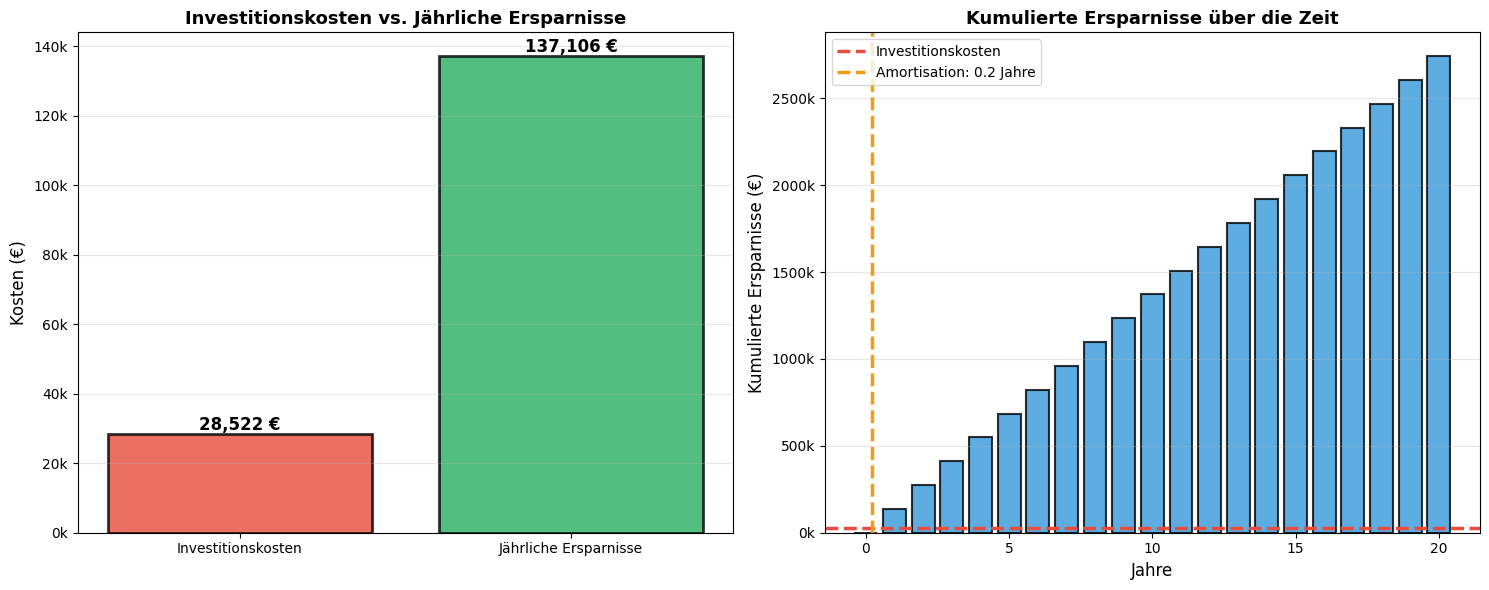


WIRTSCHAFTLICHKEITSANALYSE - ZUSAMMENFASSUNG
Gesamtinvestitionen:                 28,522 €
Jährliche Ersparnisse:              137,106 €
Amortisationszeit:                     0.21 Jahre
Ersparnisse nach 10 Jahren:       1,371,064 €
Ersparnisse nach 20 Jahren:       2,742,127 €


In [90]:
# Vergleich: Investitionskosten vs. Ersparnisse

# Investitionskosten (bereits berechnet)
total_investment_costs_plot = df_results.loc['Gesamtinvestition (€)', 'PV-Leistung 1x']  # Baseline PV-Leistung (1x)

# Jährliche Ersparnisse (bereits berechnet)
annual_savings_plot = df_results.loc['Jährliche Kosteneinsparung (€)', 'PV-Leistung 1x']  # Baseline PV-Leistung (1x)

# Erstelle das Balkendiagramm
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Diagramm 1: Investitionskosten vs. jährliche Ersparnisse
categories = ['Investitionskosten', 'Jährliche Ersparnisse']
values = [total_investment_costs_plot, annual_savings_plot]
colors = ['#E74C3C', '#27AE60']

bars1 = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Werte auf den Balken anzeigen
for bar, value in zip(bars1, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:,.0f} €',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Kosten (€)', fontsize=12)
ax1.set_title('Investitionskosten vs. Jährliche Ersparnisse', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

# Diagramm 2: Kumulierte Ersparnisse über Jahre
years = np.arange(0, 21)
cumulative_savings = years * annual_savings_plot
payback_year = total_investment_costs_plot / annual_savings_plot if annual_savings_plot > 0 else 0

ax2.bar(years, cumulative_savings, color='#3498DB', alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=total_investment_costs_plot, color='#E74C3C', linestyle='--', linewidth=2.5, label='Investitionskosten')
ax2.axvline(x=payback_year, color='#F39C12', linestyle='--', linewidth=2.5, label=f'Amortisation: {payback_year:.1f} Jahre')

ax2.set_xlabel('Jahre', fontsize=12)
ax2.set_ylabel('Kumulierte Ersparnisse (€)', fontsize=12)
ax2.set_title('Kumulierte Ersparnisse über die Zeit', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=10, loc='upper left')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

plt.tight_layout()
plt.show()

# Zusammenfassung
print("\n" + "="*70)
print("WIRTSCHAFTLICHKEITSANALYSE - ZUSAMMENFASSUNG")
print("="*70)
print(f"Gesamtinvestitionen:           {total_investment_costs_plot:>12,.0f} €")
print(f"Jährliche Ersparnisse:         {annual_savings_plot:>12,.0f} €")
print(f"Amortisationszeit:             {payback_year:>12.2f} Jahre")
print(f"Ersparnisse nach 10 Jahren:    {10 * annual_savings_plot:>12,.0f} €")
print(f"Ersparnisse nach 20 Jahren:    {20 * annual_savings_plot:>12,.0f} €")
print("="*70)

In [91]:
# Investitionskosten berechnen

# Speicher-Investitionskosten
battery_capacity = with_battery.stores.at["Battery", "e_nom_opt"]  # MWh
battery_cost = with_battery.stores.at["Battery", "capital_cost"]  # €/MWh
battery_investment = battery_capacity * battery_cost

thermal_storage_capacity = with_battery.stores.at["Thermal_Storage", "e_nom_opt"]
thermal_storage_cost = with_battery.stores.at["Thermal_Storage", "capital_cost"]
thermal_storage_investment = thermal_storage_capacity * thermal_storage_cost

dhw_storage_capacity = with_battery.stores.at["DHW_Storage", "e_nom_opt"]
dhw_storage_cost = with_battery.stores.at["DHW_Storage", "capital_cost"]
dhw_storage_investment = dhw_storage_capacity * dhw_storage_cost

# Wärmepumpen-Investitionskosten (falls Sie capital_cost hinzufügen)
h_pump_capacity = with_battery.links.at["h_pump", "p_nom_opt"]  # MW
h_pump2_capacity = with_battery.links.at["h_pump2", "p_nom_opt"]  # MW
# Beispiel: 500.000 €/MW für Wärmepumpen (Sie müssen den realen Wert einsetzen)
h_pump_cost = 500000  # €/MW
h_pump_investment = (h_pump_capacity + h_pump2_capacity) * h_pump_cost

# Gesamte Investitionskosten
total_investment = (battery_investment + thermal_storage_investment + 
                   dhw_storage_investment + h_pump_investment)

print("=" * 50)
print("INVESTITIONSKOSTEN")
print("=" * 50)
print(f"Batteriespeicher: {battery_investment:,.2f} €")
print(f"Wärmespeicher (Heizung): {thermal_storage_investment:,.2f} €")
print(f"Warmwasserspeicher: {dhw_storage_investment:,.2f} €")
print(f"Wärmepumpen: {h_pump_investment:,.2f} €")
print("=" * 50)
print(f"GESAMT: {total_investment:,.2f} €")
print("=" * 50)

INVESTITIONSKOSTEN
Batteriespeicher: 231.01 €
Wärmespeicher (Heizung): 1,869.10 €
Warmwasserspeicher: 83.86 €
Wärmepumpen: 39,500.00 €
GESAMT: 41,683.97 €


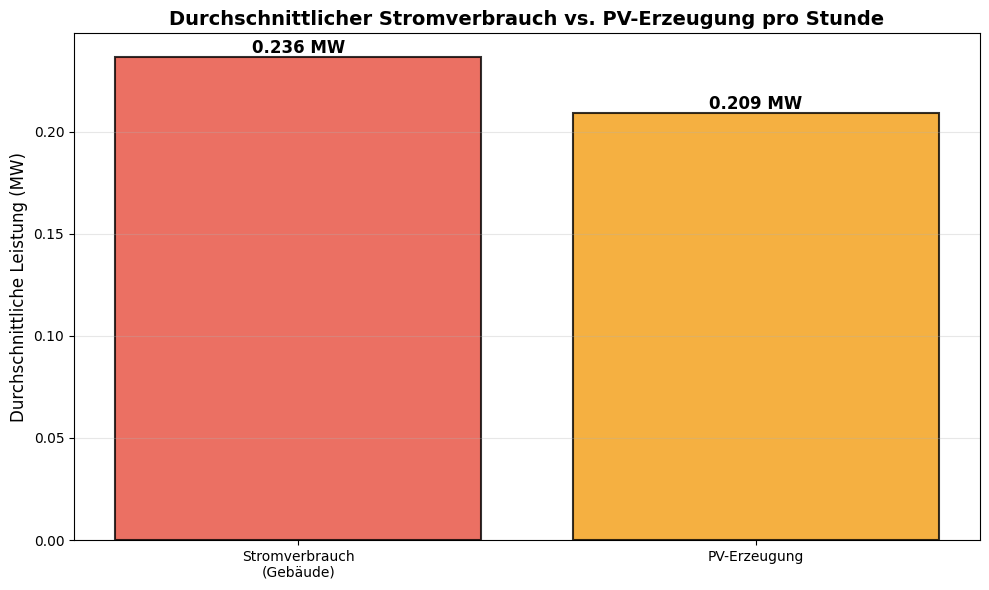

In [92]:
# Balkendiagramm: Durchschnittlicher Stromverbrauch vs. PV-Erzeugung
avg_building_load = total_electricity_demand / 8760
avg_pv_generation = pv_energy / 8760

plt.figure(figsize=(10, 6))
categories = ['Stromverbrauch\n(Gebäude)', 'PV-Erzeugung']
values = [avg_building_load, avg_pv_generation]
colors = ['#E74C3C', '#F39C12']

bars = plt.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Werte auf den Balken anzeigen
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f} MW',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Durchschnittliche Leistung (MW)', fontsize=12)
plt.title('Durchschnittlicher Stromverbrauch vs. PV-Erzeugung pro Stunde', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
Index(['0', '1', '2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 331.03it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-gojd3y7q has 175204 rows; 87604 cols; 315364 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 8e+00]
  Cost    [5e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 8e-01]
Presolving model
61320 rows, 65433 cols, 170550 nonzeros  0s
49653 rows, 53766 cols, 151481 nonzeros  0s
Dependent equations search running on 22493 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
48773 rows, 52886 cols, 155098 nonzeros  0s
Presolve reductions: rows 48773(-126431); columns 52886(-34718); nonzeros 155098(-160266) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7819544024e-03 Pr: 22763(8011.72) 0s
      22562     5.3132714365e+05 Pr: 8770(25617.1) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87604 primals, 175204 duals
Objective: 5.32e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


      27077     5.3236848834e+05 Pr: 0(0) 6s
      27077     5.3236848834e+05 Pr: 0(0) 6s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-gojd3y7q
Model status        : Optimal
Simplex   iterations: 27077
Objective value     :  5.3236848830e+05
P-D objective error :  3.7939960405e-14
HiGHS run time      :          6.44
✓ Optimiert für PV-Leistung 1x (0.35 MW)



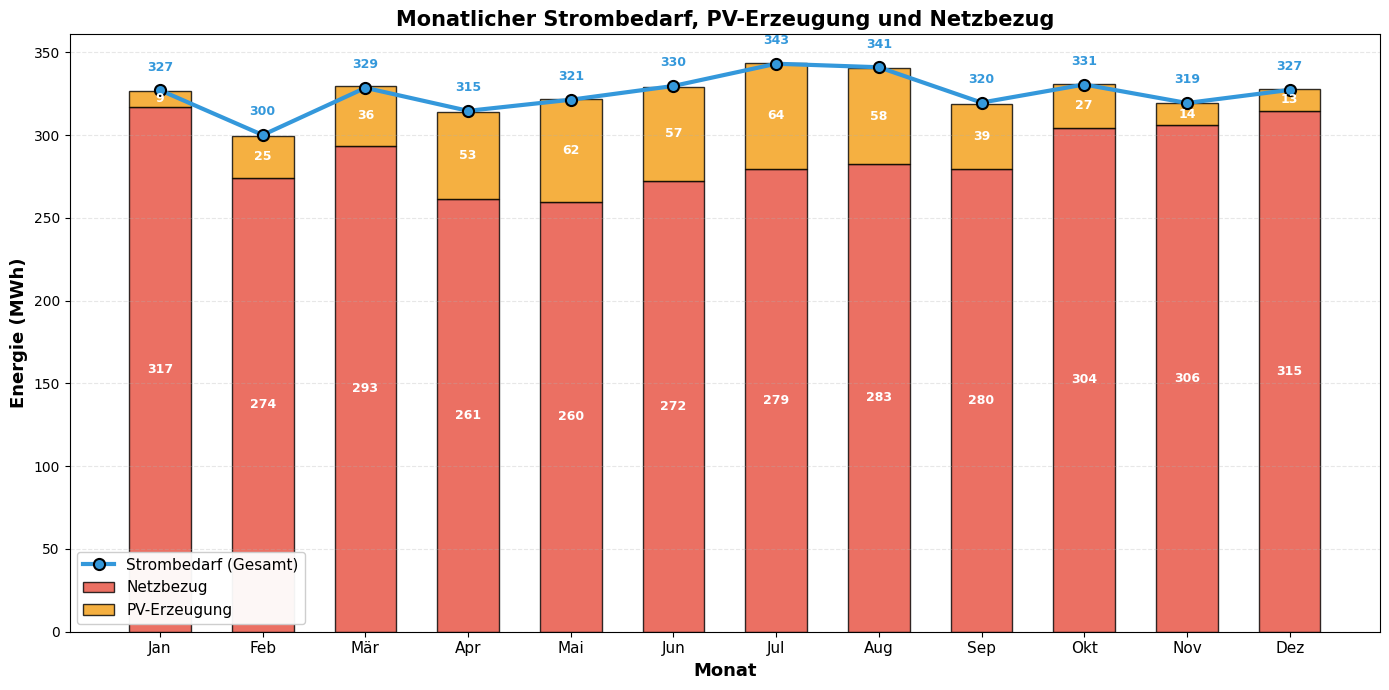


MONATLICHE ENERGIEBILANZ
Monat      Strombedarf (MWh)    PV-Erzeugung (MWh)   Netzbezug (MWh)     
--------------------------------------------------------------------------------
Jan                    327.13               9.32             317.23
Feb                    300.06              25.06             274.34
Mär                    328.56              36.46             293.36
Apr                    314.65              52.95             261.12
Mai                    321.36              62.42             259.52
Jun                    329.69              56.89             272.22
Jul                    343.11              64.22             279.46
Aug                    340.98              57.86             282.54
Sep                    319.63              39.36             279.60
Okt                    330.55              26.65             304.40
Nov                    319.38              13.64             305.91
Dez                    327.29              13.26             314.61
---

In [93]:
# Monatlicher Plot: Strombedarf vs. PV-Erzeugung vs. Netzbezug

# ========================================
# WÄHLE HIER DAS SZENARIO:
selected_pv_multiplier = 1  # 0.0 0.5, 1, 1.5, 2, 2.5
# ========================================

# Optimiere für das gewählte Szenario
selected_pv = inhouse_pv * selected_pv_multiplier
with_battery.generators.at["PV", "p_nom"] = selected_pv
with_battery.optimize(solver_name='highs')
print(f"✓ Optimiert für PV-Leistung {selected_pv_multiplier}x ({selected_pv:.2f} MW)\n")

# Berechne Stunden pro Monat
hours_per_month = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]  # 2024 (Schaltjahr)
months = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']

# Extrahiere stündliche Daten
total_load = (with_battery.loads_t.p["building_load"] + 
              with_battery.loads_t.p["fleet_load"] + 
              with_battery.links_t.p0["h_pump"] + 
              with_battery.links_t.p0["h_pump2"]).values

pv_generation = with_battery.generators_t.p["PV"].values
grid_supply = with_battery.generators_t.p["Grid"].values

# Berechne monatliche Summen
monthly_load = []
monthly_pv = []
monthly_grid = []

start_hour = 0
for hours in hours_per_month:
    end_hour = start_hour + hours
    monthly_load.append(total_load[start_hour:end_hour].sum())
    monthly_pv.append(pv_generation[start_hour:end_hour].sum())
    monthly_grid.append(grid_supply[start_hour:end_hour].sum())
    start_hour = end_hour

# Erstelle Stacked Area Chart mit zusätzlichem Netzbezug
fig, ax = plt.subplots(figsize=(14, 7))

x_pos = np.arange(len(months))
width = 0.6

# Stacked Bar Chart: Netzbezug + PV-Erzeugung
bars1 = ax.bar(x_pos, monthly_grid, width, label='Netzbezug', color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1)
bars2 = ax.bar(x_pos, monthly_pv, width, bottom=monthly_grid, label='PV-Erzeugung', color='#F39C12', alpha=0.8, edgecolor='black', linewidth=1)

# Line für Gesamtbedarf
line = ax.plot(x_pos, monthly_load, color='#3498DB', linewidth=3, marker='o', markersize=8, label='Strombedarf (Gesamt)', linestyle='-', markeredgecolor='black', markeredgewidth=1.5)

# Werte auf den Balken anzeigen
for i, (grid, pv) in enumerate(zip(monthly_grid, monthly_pv)):
    # Netzbezug
    if grid > 0:
        ax.text(i, grid/2, f'{grid:.0f}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # PV-Erzeugung
    if pv > 0:
        ax.text(i, grid + pv/2, f'{pv:.0f}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Strombedarf (auf der Linie)
    ax.text(i, monthly_load[i] + 10, f'{monthly_load[i]:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='#3498DB')

# Formatierung
ax.set_xlabel('Monat', fontsize=13, fontweight='bold')
ax.set_ylabel('Energie (MWh)', fontsize=13, fontweight='bold')
ax.set_title('Monatlicher Strombedarf, PV-Erzeugung und Netzbezug', fontsize=15, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(months, fontsize=11)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Y-Achsen-Formatter
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.tight_layout()
plt.show()

# Tabellarische Zusammenfassung
print("\n" + "="*80)
print("MONATLICHE ENERGIEBILANZ")
print("="*80)
print(f"{'Monat':<10} {'Strombedarf (MWh)':<20} {'PV-Erzeugung (MWh)':<20} {'Netzbezug (MWh)':<20}")
print("-"*80)

for month, load, pv, grid in zip(months, monthly_load, monthly_pv, monthly_grid):
    print(f"{month:<10} {load:>18,.2f} {pv:>18,.2f} {grid:>18,.2f}")

print("-"*80)
print(f"{'GESAMT':<10} {sum(monthly_load):>18,.2f} {sum(monthly_pv):>18,.2f} {sum(monthly_grid):>18,.2f}")
print("="*80)

# Autarkie pro Monat
print("\n" + "="*80)
print("MONATLICHE AUTARKIE")
print("="*80)
for month, pv, load in zip(months, monthly_pv, monthly_load):
    autarkiequote = (pv / load * 100) if load > 0 else 0
    print(f"{month:<10} {autarkiequote:>6.2f}% (PV: {pv:>7.2f} MWh / Bedarf: {load:>7.2f} MWh)")
print("="*80)
